In [27]:
%load_ext autoreload
%autoreload 2

from clust_newlambda import *



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [28]:
%load_ext autoreload
%autoreload 2



%autoreload 2
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from scipy.spatial.distance import pdist, squareform
from scipy.special import expit
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
from sklearn.cluster import SpectralClustering  # Add this import

def load_model_essentials(base_path='/Users/sarahurbut/Dropbox (Personal)/data_for_running/'):
    """
    Load all essential components
    """
    print("Loading components...")
    
    # Load large matrices
    Y = torch.load(base_path + 'Y_tensor.pt')
    E = torch.load(base_path + 'E_matrix.pt')
    G = torch.load(base_path + 'G_matrix.pt')
    
    # Load other components
    essentials = torch.load(base_path + 'model_essentials.pt')
    
    print("Loaded all components successfully!")
    
    return Y, E, G, essentials

# Load and initialize model:
Y, E, G, essentials = load_model_essentials()


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Loading components...


/var/folders/2f/nxrbr3pn1msgrl4ffyj33zd00000gn/T/ipykernel_57289/1184199116.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  Y = torch.load(base_path + 'Y_tensor.pt')
/v

Loaded all components successfully!


In [29]:

# Subset the data
Y_100k, E_100k, G_100k, indices = subset_data(Y, E, G, start_index=0, end_index=10000)

torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
# Initialize model with subsetted data

del Y

In [30]:
# When initializing the model:
original_G = G_100k # Store the original G - proper tensor copy

# Now in your batch run, load and verify:
initial_psi = torch.load('initial_psi_400k.pt')
initial_clusters = torch.load('initial_clusters_400k.pt')

original_cluster_sizes = {}
unique, counts = np.unique(initial_clusters, return_counts=True)
for k, count in zip(unique, counts):
    original_cluster_sizes[k] = count
print("\nOriginal cluster sizes:")
for k, count in original_cluster_sizes.items():
    print(f"Cluster {k}: {count} diseases")


Original cluster sizes:
Cluster 0: 16 diseases
Cluster 1: 21 diseases
Cluster 2: 15 diseases
Cluster 3: 82 diseases
Cluster 4: 5 diseases
Cluster 5: 7 diseases
Cluster 6: 8 diseases
Cluster 7: 22 diseases
Cluster 8: 28 diseases
Cluster 9: 12 diseases
Cluster 10: 11 diseases
Cluster 11: 8 diseases
Cluster 12: 7 diseases
Cluster 13: 13 diseases
Cluster 14: 10 diseases
Cluster 15: 5 diseases
Cluster 16: 29 diseases
Cluster 17: 17 diseases
Cluster 18: 9 diseases
Cluster 19: 23 diseases


/var/folders/2f/nxrbr3pn1msgrl4ffyj33zd00000gn/T/ipykernel_57289/1949801412.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  initial_psi = torch.load('initial_psi_400k.pt

In [31]:
print("Initial psi stats:")
print(f"Shape: {initial_psi.shape}")
print(f"Range: [{initial_psi.min():.2f}, {initial_psi.max():.2f}]")
print(f"Number of positive values: {(initial_psi > 0).sum().item()}")



Initial psi stats:
Shape: torch.Size([20, 348])
Range: [-2.04, 1.33]
Number of positive values: 348


In [38]:
# Load references (signatures only, no healthy)
refs = torch.load('reference_trajectories.pt')
signature_refs = refs['signature_refs']
# When initializing the model:

# Now in your batch run, load and verify:
initial_psi = torch.load('initial_psi_400k.pt')
initial_clusters = torch.load('initial_clusters_400k.pt')


/var/folders/2f/nxrbr3pn1msgrl4ffyj33zd00000gn/T/ipykernel_57289/2429096507.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  refs = torch.load('reference_trajectories.pt'

In [39]:

torch.manual_seed(7)
np.random.seed(4)
# Create model without healthy reference
model = AladynSurvivalFixedKernelsAvgLoss_clust_logitInit_psitest(
    N=Y_100k.shape[0], 
    D=Y_100k.shape[1], 
    T=Y_100k.shape[2], 
    K=20,
    P=G_100k.shape[1],
    init_var_scaler=1e-1,
    G=G_100k, 
    Y=Y_100k,
    genetic_scale=1,
    prevalence_t=essentials['prevalence_t'],
    signature_references=signature_refs,  # Only pass signature refs
    healthy_reference=True,  # Explicitly set to None
    disease_names=essentials['disease_names']
)

torch.manual_seed(0)
np.random.seed(0)
# Initialize with psi and clusters
model.initialize_params(true_psi=initial_psi)
model.clusters = initial_clusters
# Verify clusters match
clusters_match = np.array_equal(initial_clusters, model.clusters)
print(f"\nClusters match exactly: {clusters_match}")

/Users/sarahurbut/aladynoulli2/pyScripts/clust_newlambda.py:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.signature_refs = torch.tensor(signature_references, dtype=torch.float32)
/Users/sarahurbut/aladynoulli2/pyScripts/clust_newlambda.py:72: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.G = torch.tensor(G, dtype=torch.float32)
/Users/sarahurbut/aladynoulli2/pyScripts/clust_newlambda.py:75: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.G = torch.tensor(G_scaled, dtype=torch.float32)
/Users/sarahurbut/aladynoulli2/pyScri


Cluster Sizes:
Cluster 0: 14 diseases
Cluster 1: 7 diseases
Cluster 2: 21 diseases
Cluster 3: 15 diseases
Cluster 4: 17 diseases
Cluster 5: 16 diseases
Cluster 6: 57 diseases
Cluster 7: 18 diseases
Cluster 8: 13 diseases
Cluster 9: 11 diseases
Cluster 10: 18 diseases
Cluster 11: 12 diseases
Cluster 12: 26 diseases
Cluster 13: 7 diseases
Cluster 14: 9 diseases
Cluster 15: 8 diseases
Cluster 16: 7 diseases
Cluster 17: 11 diseases
Cluster 18: 6 diseases
Cluster 19: 55 diseases

Calculating gamma for k=0:
Number of diseases in cluster: 14
Base value (first 5): tensor([-18.4207, -18.4207, -17.3858, -16.3508, -16.3508])
Base value centered (first 5): tensor([-0.5458, -0.5458,  0.4891,  1.5240,  1.5240])
Base value centered mean: 3.23352810482902e-06
Gamma init for k=0 (first 5): tensor([ 0.0013,  0.0101,  0.0173,  0.0224, -0.0156])

Calculating gamma for k=1:
Number of diseases in cluster: 7
Base value (first 5): tensor([-18.4207, -18.4207, -18.4207, -18.4207, -18.4207])
Base value centered

In [40]:
print(model.K_total)
print(model.K)

21
20


In [41]:
history_new = model.fit(E_100k, num_epochs=20, learning_rate=1e-2, lambda_reg=1e-2)
        

/Users/sarahurbut/aladynoulli2/pyScripts/clust_newlambda.py:241: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  event_times_tensor = torch.tensor(event_times, dtype=torch.long)


Data loss: 65.6950
GP loss: 5.6859
LRT loss: 16456.7656

Epoch 0
Loss: 71.3841

Monitoring signature responses:

Disease 161 (signature 7, LR=32.12):
  Theta for diagnosed: 0.150 ± 0.035
  Theta for others: 0.147
  Proportion difference: 0.003

Disease 76 (signature 7, LR=30.76):
  Theta for diagnosed: 0.149 ± 0.036
  Theta for others: 0.147
  Proportion difference: 0.003

Disease 260 (signature 8, LR=30.40):
  Theta for diagnosed: 0.088 ± 0.073
  Theta for others: 0.087
  Proportion difference: 0.001

Disease 347 (signature 3, LR=29.41):
  Theta for diagnosed: 0.148 ± 0.068
  Theta for others: 0.149
  Proportion difference: -0.001

Disease 50 (signature 15, LR=28.85):
  Theta for diagnosed: 0.016 ± 0.006
  Theta for others: 0.014
  Proportion difference: 0.002
Data loss: 65.6198
GP loss: 459.7293
LRT loss: 16413.8711

Epoch 1
Loss: 525.3523

Monitoring signature responses:

Disease 161 (signature 7, LR=32.12):
  Theta for diagnosed: 0.149 ± 0.034
  Theta for others: 0.146
  Proportion

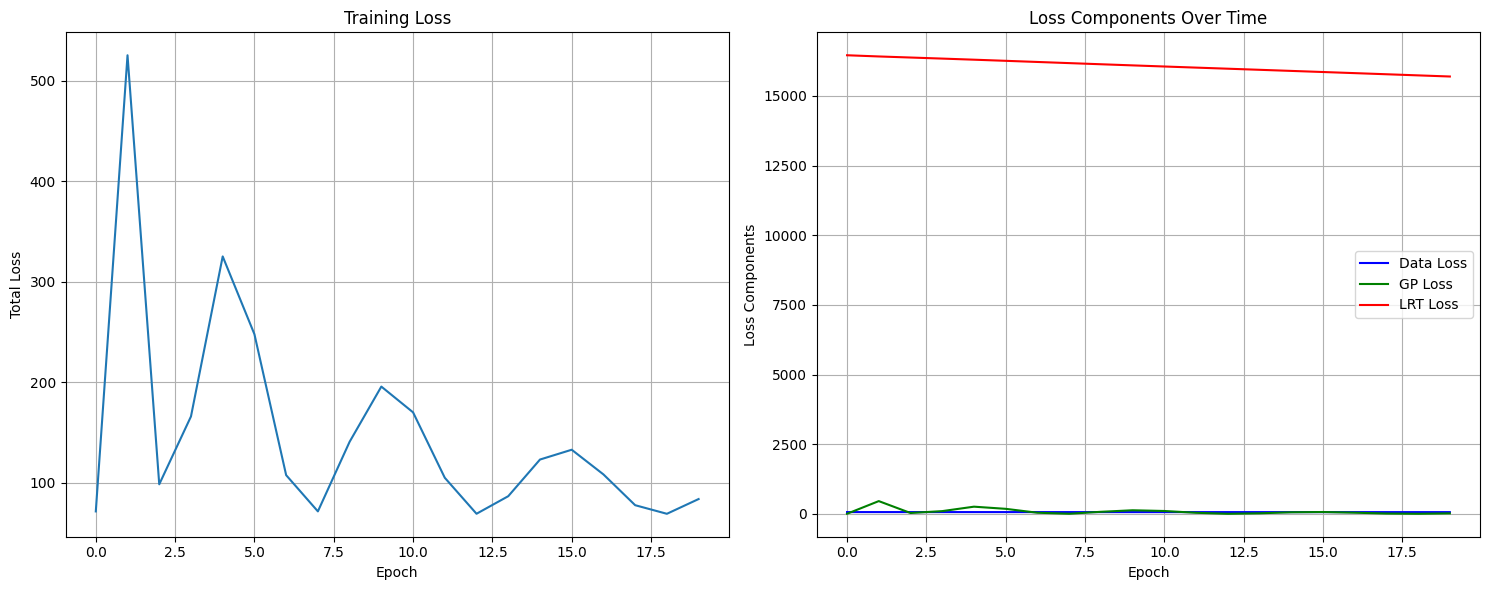

In [49]:
def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Plot total loss
    ax1.plot(history)
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Total Loss')
    ax1.set_title('Training Loss')
    ax1.grid(True)

    # Plot component losses
    # Extract from printed output
    epochs = range(len(history))
    data_losses = [65.6950, 65.6198, 65.5456, 65.4711, 65.3961, 65.3208, 65.2452, 65.1694, 65.0936, 65.0177, 64.9418, 64.8659, 64.7899, 64.7138, 64.6375, 64.5610, 64.4845, 64.4078, 64.3310, 64.2542]
    gp_losses = [5.6859, 459.7293, 32.8175, 100.4279, 259.7525, 182.3966, 42.2339, 6.2529, 75.5871, 130.6093, 105.0365, 40.0023, 4.2676, 21.8158, 58.3701, 68.2091, 43.7377, 13.1755, 4.6903, 19.4461]
    lrt_losses = [16456.7656, 16413.8711, 16375.5742, 16337.2236, 16297.7764, 16257.2930, 16216.2754, 16175.0986, 16134.0918, 16093.5273, 16053.4570, 16013.7744, 15974.3174, 15934.9131, 15895.3779, 15855.5889, 15815.5312, 15775.2656, 15734.9033, 15694.5830]

    ax2.plot(epochs, data_losses, label='Data Loss', color='blue')
    ax2.plot(epochs, gp_losses, label='GP Loss', color='green')
    ax2.plot(epochs, lrt_losses, label='LRT Loss', color='red')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss Components')
    ax2.set_title('Loss Components Over Time')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

# Call the plotting function
plot_training_history(history_new)

In [42]:
final_lambda = model.lambda_.detach().clone()
diff = torch.abs(final_lambda - initial_lambda)

print(f"Lambda changes with lr=1e-4:")
print(f"Mean absolute change: {torch.mean(diff):.3e}")
print(f"Max absolute change: {torch.max(diff):.3e}")
print(f"Std of changes: {torch.std(diff):.3e}")

Lambda changes with lr=1e-4:
Mean absolute change: 1.339e-01
Max absolute change: 2.099e-01
Std of changes: 5.845e-02


In [43]:
clusters_match = np.array_equal(initial_clusters, model.clusters)
print(f"\nClusters match exactly: {clusters_match}")


Clusters match exactly: True


In [46]:
def plot_theta_differences():
    diseases = [161, 76, 260, 347, 50]
    signatures = [7, 7, 8, 3, 15]
    
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()
    
    for i, (d, sig) in enumerate(zip(diseases, signatures)):
        ax = axes[i]
        
        # Get diagnosis times
        diagnosis_mask = model.Y[:, d, :].bool()
        diagnosed = torch.where(diagnosis_mask)[0]
        
        # Get thetas
        pi, theta, phi_prob = model.forward()
        
        # Plot distributions
        diagnosed_theta = theta[diagnosis_mask, sig].detach().numpy()
        others_theta = theta[~diagnosis_mask, sig].detach().numpy()
        
        ax.hist(diagnosed_theta, alpha=0.5, label='At diagnosis', density=True)
        ax.hist(others_theta, alpha=0.5, label='Others', density=True)
        
        ax.set_title(f'Disease {d} (sig {sig})')
        ax.set_xlabel('Theta')
        ax.set_ylabel('Density')
        ax.legend()
    
    plt.tight_layout()
    plt.show()

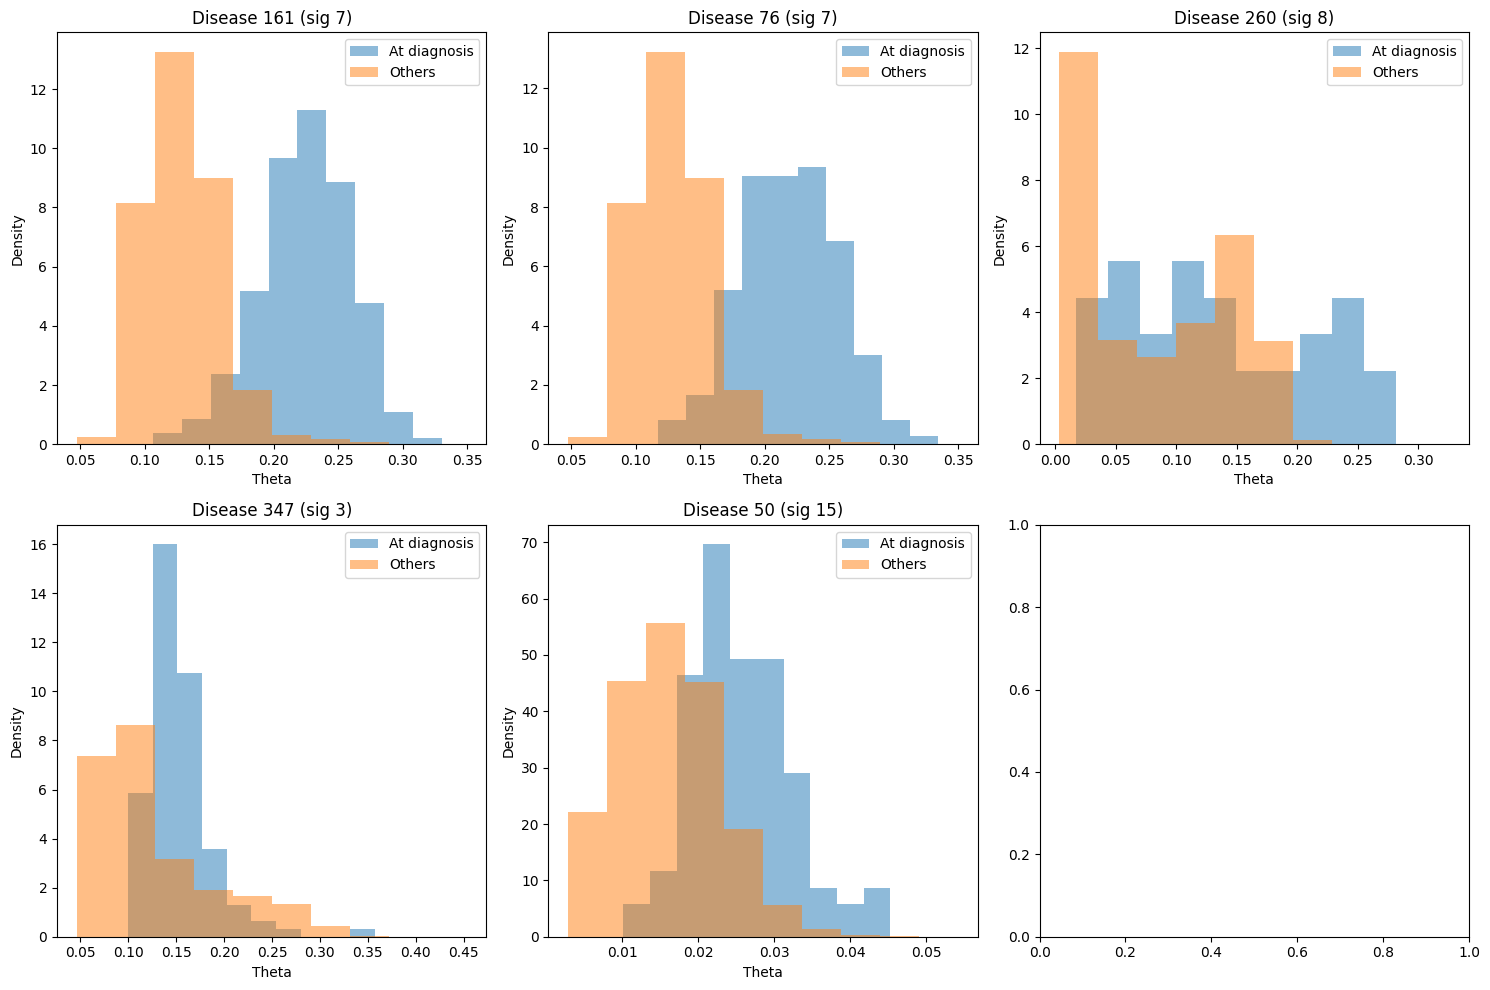

In [48]:
plot_theta_differences()

In [50]:
# Get μ_dt from checkpoint and predictions
mu_dt = model.prevalence_t  # Shape: (348, 52)



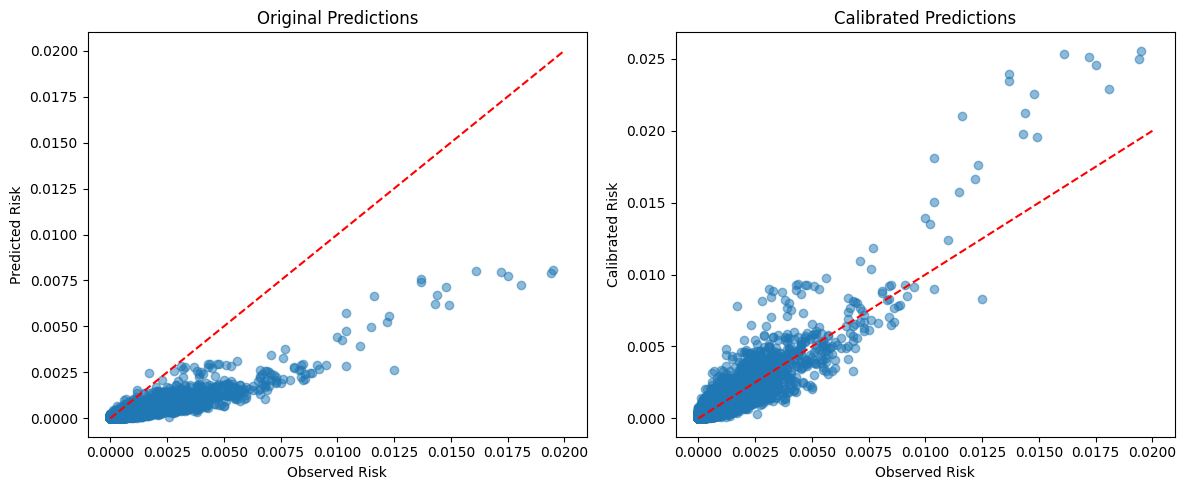

Mean observed risk: 0.000438
Mean predicted risk (original): 0.000138
Mean predicted risk (calibrated): 0.000438
Calibration scale factor: 3.163


In [51]:
# 1. Get predictions and actual values
predicted = model.forward()
pi_pred = predicted[0] if isinstance(predicted, tuple) else predicted
pi_pred = pi_pred.cpu().detach().numpy()
Y = model.Y.cpu().detach().numpy()

# 2. Calculate marginal risks directly
# Assuming dimensions are: [N, D, T] for both Y and pi_pred
observed_risk = Y.mean(axis=0).flatten()  # average across individuals
predicted_risk = pi_pred.mean(axis=0).flatten()
#observed_risk=mu_dt_flat
# 3. Apply calibration
scale_factor = np.mean(observed_risk) / np.mean(predicted_risk)
calibrated_risk = predicted_risk * scale_factor

# 4. Plot
plt.figure(figsize=(12, 5))

# Original predictions
plt.subplot(121)
plt.scatter(observed_risk, predicted_risk, alpha=0.5)
plt.plot([0, 0.02], [0, 0.02], 'r--')  # y=x line
plt.title('Original Predictions')
plt.xlabel('Observed Risk')
plt.ylabel('Predicted Risk')

# Calibrated predictions
plt.subplot(122)
plt.scatter(observed_risk, calibrated_risk, alpha=0.5)
plt.plot([0, 0.02], [0, 0.02], 'r--')  # y=x line
plt.title('Calibrated Predictions')
plt.xlabel('Observed Risk')
plt.ylabel('Calibrated Risk')

plt.tight_layout()
plt.show()

# Print statistics
print(f"Mean observed risk: {np.mean(observed_risk):.6f}")
print(f"Mean predicted risk (original): {np.mean(predicted_risk):.6f}")
print(f"Mean predicted risk (calibrated): {np.mean(calibrated_risk):.6f}")
print(f"Calibration scale factor: {scale_factor:.3f}")


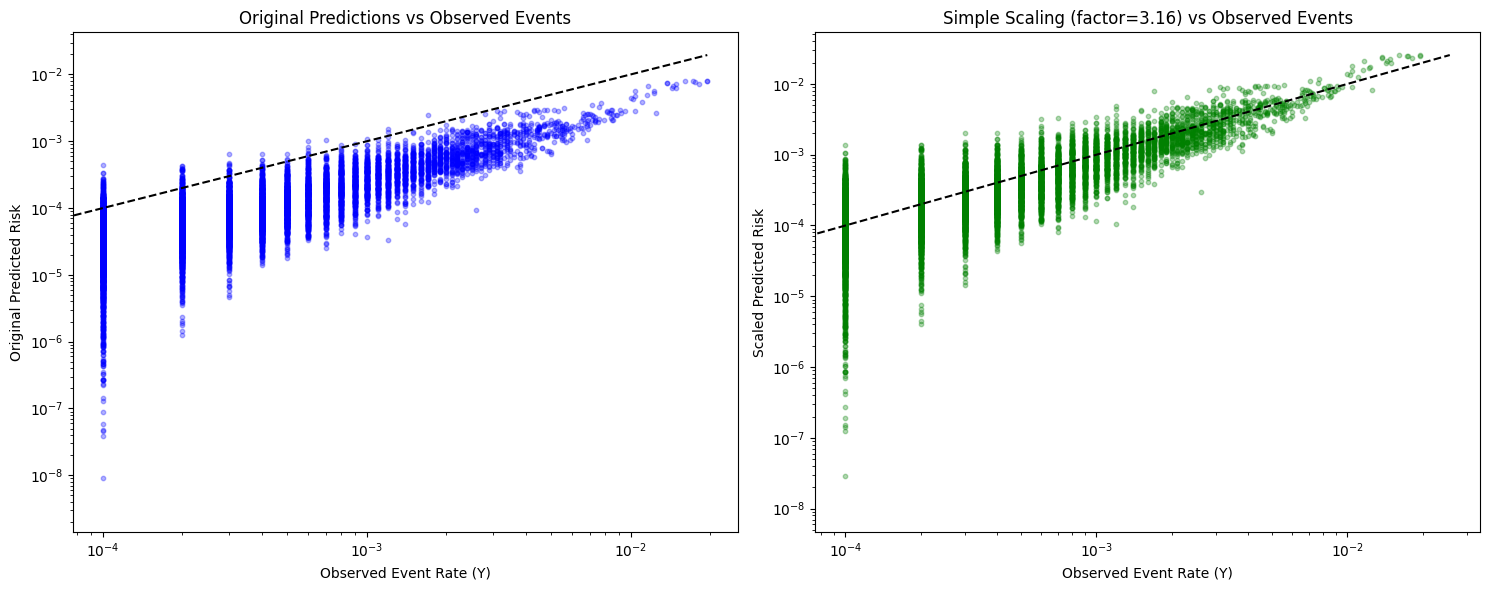

Scale factor: 3.163


In [52]:
# Get predictions
predicted = model.forward()
pi_pred = predicted[0] if isinstance(predicted, tuple) else predicted
predicted_risk_2d = pi_pred.cpu().detach().numpy().mean(axis=0)  # average across individuals

# Get raw observations and calculate scale factor
Y_np = model.Y.cpu().detach().numpy()
Y_mean_2d = Y_np.mean(axis=0)  # average across individuals
scale_factor = Y_mean_2d.mean() / predicted_risk_2d.mean()
scaled_risk_2d = predicted_risk_2d * scale_factor

# Create plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Original predictions vs raw observations
ax1.scatter(Y_mean_2d.flatten(), predicted_risk_2d.flatten(), 
           alpha=0.3, color='blue', s=10)
ax1.plot([0, max(Y_mean_2d.max(), predicted_risk_2d.max())], 
         [0, max(Y_mean_2d.max(), predicted_risk_2d.max())], 
         'k--', label='x=y')
ax1.set_xlabel('Observed Event Rate (Y)')
ax1.set_ylabel('Original Predicted Risk')
ax1.set_title('Original Predictions vs Observed Events')
ax1.set_xscale('log')
ax1.set_yscale('log')

# Scaled predictions vs raw observations
ax2.scatter(Y_mean_2d.flatten(), scaled_risk_2d.flatten(), 
           alpha=0.3, color='green', s=10)
ax2.plot([0, max(Y_mean_2d.max(), scaled_risk_2d.max())], 
         [0, max(Y_mean_2d.max(), scaled_risk_2d.max())], 
         'k--', label='x=y')
ax2.set_xlabel('Observed Event Rate (Y)')
ax2.set_ylabel('Scaled Predicted Risk')
ax2.set_title(f'Simple Scaling (factor={scale_factor:.2f}) vs Observed Events')
ax2.set_xscale('log')
ax2.set_yscale('log')

plt.tight_layout()
plt.show()

print(f"Scale factor: {scale_factor:.3f}")

In [53]:

ss_res = np.sum((observed_risk - calibrated_risk) ** 2)
ss_tot = np.sum((observed_risk - np.mean(observed_risk)) ** 2)
r2 = 1 - (ss_res / ss_tot)

print(f"R^2: {r2:.3f}")

R^2: 0.777


In [54]:
def plot_signature_top_diseases_centered(model, disease_names, n_top=10):
    """
    Show top diseases for each signature, centered relative to prevalence
    """
    # Get phi and prevalence
    phi = model.phi.detach().numpy()  # Shape: (K, D, T)
    prevalence_logit = model.logit_prev_t.detach().numpy()  # Shape: (D, T)
    
    # Center phi relative to prevalence
    phi_centered = np.zeros_like(phi)
    for k in range(phi.shape[0]):
        for d in range(phi.shape[1]):
            phi_centered[k, d, :] = phi[k, d, :] - prevalence_logit[d, :]
    
    # Average over time
    phi_avg = phi_centered.mean(axis=2)  # Shape: (K, D)
    
    # For each signature, get top diseases
    for k in range(phi_avg.shape[0]):
        scores = phi_avg[k, :]
        top_indices = np.argsort(scores)[-n_top:][::-1]
        
        print(f"\nTop {n_top} diseases in Signature {k} (relative to baseline):")
        for idx in top_indices:
            avg_effect = scores[idx]
            temporal_std = np.std(phi_centered[k, idx, :])
            # Convert to odds ratio for interpretability
            odds_ratio = np.exp(avg_effect)
            print(f"{disease_names[idx]}: effect={avg_effect:.3f} (OR={odds_ratio:.2f}), std={temporal_std:.3f}")

# Run visualization
plot_signature_top_diseases_centered(model, essentials['disease_names'])


Top 10 diseases in Signature 0 (relative to baseline):
Paroxysmal ventricular tachycardia: effect=1.215 (OR=3.37), std=0.059
Aortic valve disease: effect=1.179 (OR=3.25), std=0.025
Heart failure NOS: effect=1.147 (OR=3.15), std=0.032
Congestive heart failure (CHF) NOS: effect=1.038 (OR=2.82), std=0.041
Pericarditis: effect=1.035 (OR=2.82), std=0.134
Left bundle branch block: effect=1.000 (OR=2.72), std=0.070
Cardiomegaly: effect=0.984 (OR=2.68), std=0.009
Mitral valve disease: effect=0.953 (OR=2.59), std=0.060
Congenital anomalies of great vessels: effect=0.953 (OR=2.59), std=0.035
Disease of tricuspid valve: effect=0.926 (OR=2.52), std=0.071

Top 10 diseases in Signature 1 (relative to baseline):
Enthesopathy: effect=1.237 (OR=3.44), std=0.022
Hallux valgus (Bunion): effect=1.179 (OR=3.25), std=0.040
Other disorders of synovium, tendon, and bursa: effect=1.161 (OR=3.19), std=0.019
Other peripheral nerve disorders: effect=1.125 (OR=3.08), std=0.154
Peripheral enthesopathies and allied

In [55]:
def compare_disease_rankings(model, disease_names, n_top=10):
    """
    Compare initial vs final disease rankings for each signature
    """
    # Get initial rankings from psi
    psi = model.psi.detach().numpy()  # Shape: (K, D)
    
    # Get final rankings from centered phi
    phi = model.phi.detach().numpy()  # Shape: (K, D, T)
    prevalence_logit = model.logit_prev_t.detach().numpy()  # Shape: (D, T)
    
    # Center phi relative to prevalence
    phi_centered = np.zeros_like(phi)
    for k in range(phi.shape[0]):
        for d in range(phi.shape[1]):
            phi_centered[k, d, :] = phi[k, d, :] - prevalence_logit[d, :]
    
    # Average over time
    phi_avg = phi_centered.mean(axis=2)  # Shape: (K, D)
    
    # Compare rankings for each signature
    for k in range(phi_avg.shape[0]):
        print(f"\nSignature {k}:")
        
        # Get initial top diseases from psi
        initial_scores = psi[k, :]
        initial_top = np.argsort(initial_scores)[-n_top:][::-1]
        
        # Get final top diseases from phi
        final_scores = phi_avg[k, :]
        final_top = np.argsort(final_scores)[-n_top:][::-1]
        
        print("\nInitial top diseases:")
        for i, idx in enumerate(initial_top):
            print(f"{i+1}. {disease_names[idx]}: {initial_scores[idx]:.3f}")
            
        print("\nFinal top diseases:")
        for i, idx in enumerate(final_top):
            print(f"{i+1}. {disease_names[idx]}: {final_scores[idx]:.3f}")
            
        # Calculate rank changes
        initial_ranks = {disease: rank for rank, disease in enumerate(initial_top)}
        final_ranks = {disease: rank for rank, disease in enumerate(final_top)}
        
        # Find diseases that changed ranks significantly
        changed_diseases = set(initial_top) | set(final_top)
        for disease in changed_diseases:
            initial_rank = initial_ranks.get(disease, n_top+1)
            final_rank = final_ranks.get(disease, n_top+1)
            if abs(final_rank - initial_rank) > 2:  # Threshold for significant change
                print(f"\n{disease_names[disease]} changed from rank {initial_rank+1} to {final_rank+1}")

# Run comparison
compare_disease_rankings(model, essentials['disease_names'])


Signature 0:

Initial top diseases:
1. Paroxysmal ventricular tachycardia: 1.243
2. Heart failure NOS: 1.209
3. Aortic valve disease: 1.160
4. Pericarditis: 1.062
5. Left bundle branch block: 1.045
6. Disease of tricuspid valve: 1.000
7. Congenital anomalies of great vessels: 0.944
8. Cardiomegaly: 0.928
9. Congestive heart failure (CHF) NOS: 0.920
10. Paroxysmal supraventricular tachycardia: 0.916

Final top diseases:
1. Paroxysmal ventricular tachycardia: 1.215
2. Aortic valve disease: 1.179
3. Heart failure NOS: 1.147
4. Congestive heart failure (CHF) NOS: 1.038
5. Pericarditis: 1.035
6. Left bundle branch block: 1.000
7. Cardiomegaly: 0.984
8. Mitral valve disease: 0.953
9. Congenital anomalies of great vessels: 0.953
10. Disease of tricuspid valve: 0.926

Congestive heart failure (CHF) NOS changed from rank 9 to 4

Mitral valve disease changed from rank 12 to 8

Disease of tricuspid valve changed from rank 6 to 10

Signature 1:

Initial top diseases:
1. Enthesopathy: 1.213
2. Hal

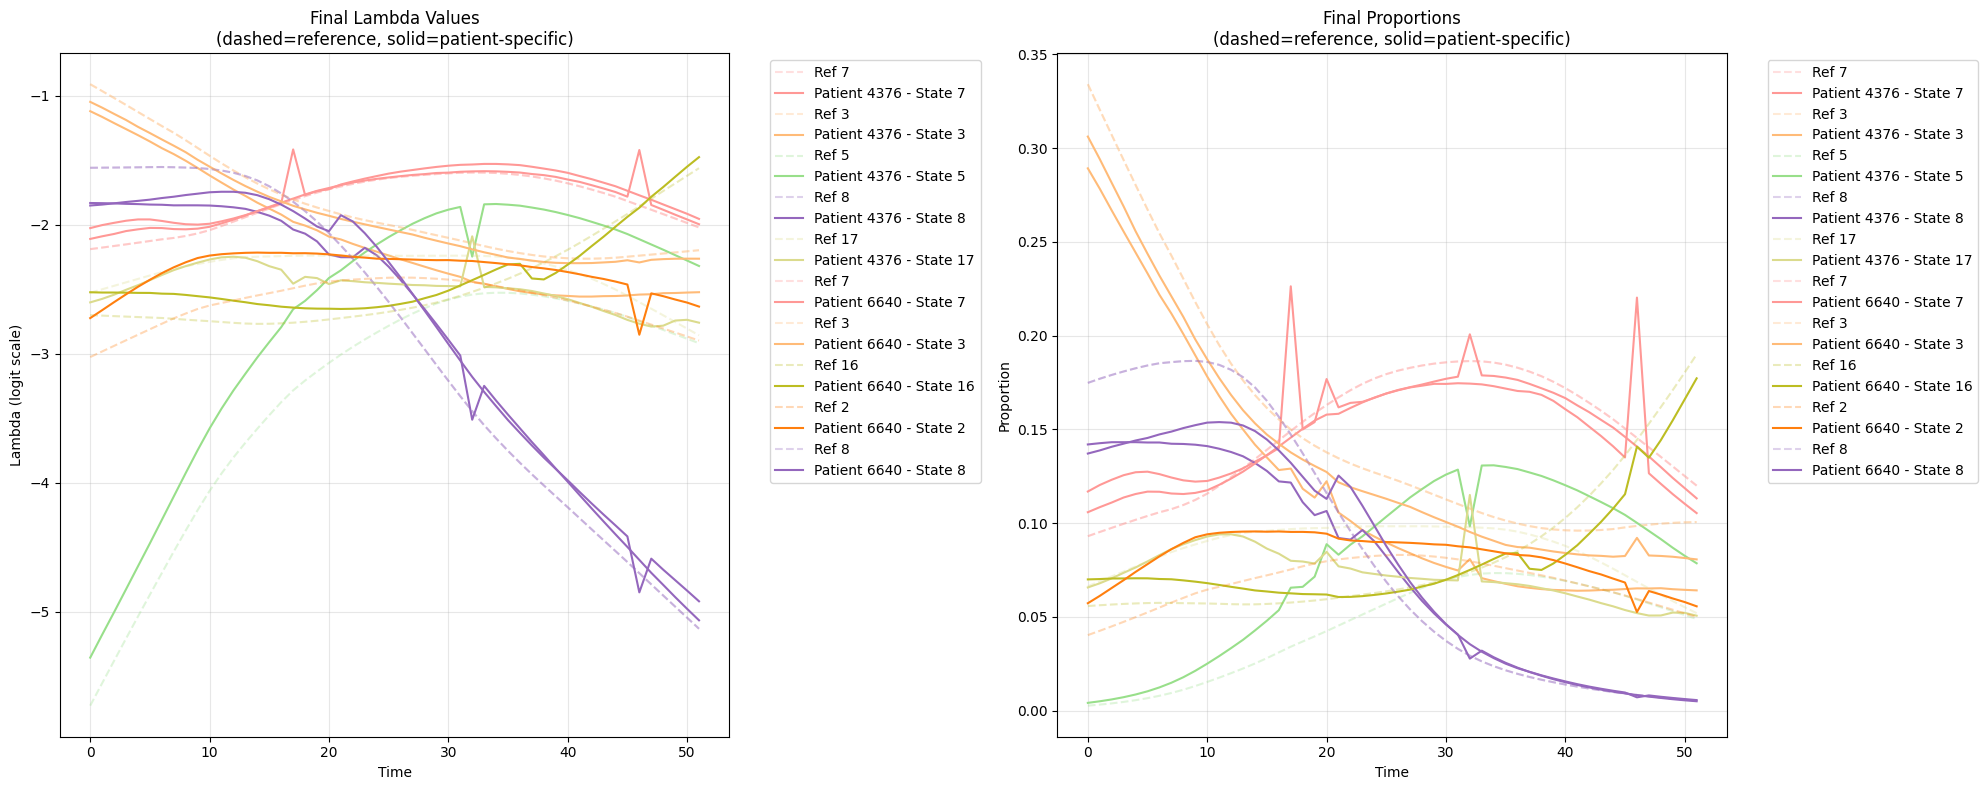


Genetic Effect Statistics for Sample Patients:

Patient 4376:
Mean shift: 0.063
Std of shifts: 0.139
Range of shifts: [-0.131, 0.461]

Top states and average proportions:
State 7: 0.151
State 3: 0.120
State 5: 0.078
State 8: 0.075
State 17: 0.073

Patient 6640:
Mean shift: 0.040
Std of shifts: 0.079
Range of shifts: [-0.164, 0.232]

Top states and average proportions:
State 7: 0.145
State 3: 0.137
State 16: 0.082
State 2: 0.082
State 8: 0.080


In [56]:
# Sample patients and set parameters
n_samples = 2
sample_patients = [4376, 6640]  # Use specific patients
n_top_states = 5  # Show only top 5 states per patient

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
time_points = np.arange(model.T)

# Get dominant states for these patients
lambda_patients = model.lambda_[sample_patients]  # [2, K, T]
patient_props = torch.softmax(lambda_patients, dim=1)  # [2, K, T]
mean_props = patient_props.mean(dim=-1)  # Average over time, now [2, K]
top_states = mean_props.topk(n_top_states, dim=-1).indices  # Get top states for each patient

# Color map for consistent colors across patients
colors = plt.cm.tab20(np.linspace(0, 1, model.K))

# Plot for each patient
for i, patient in enumerate(sample_patients):
    for j, k in enumerate(top_states[i]):
        k = k.item()  # Convert tensor to int
        color = colors[k]
        
        # Plot lambda values
        ax1.plot(time_points, signature_refs[k], '--', color=color, alpha=0.3, 
                label=f'Ref {k}')
        ax1.plot(time_points, model.lambda_[patient, k].detach(), '-', color=color,
                label=f'Patient {patient} - State {k}')
        
        # Plot proportions
        ref_props = torch.softmax(signature_refs, dim=0)[k]
        patient_props = torch.softmax(model.lambda_[patient].detach(), dim=0)[k]
        ax2.plot(time_points, ref_props, '--', color=color, alpha=0.3, 
                label=f'Ref {k}')
        ax2.plot(time_points, patient_props, '-', color=color,
                label=f'Patient {patient} - State {k}')

# Customize plots
ax1.set_title('Final Lambda Values\n(dashed=reference, solid=patient-specific)')
ax1.set_xlabel('Time')
ax1.set_ylabel('Lambda (logit scale)')
ax1.grid(True, alpha=0.3)
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

ax2.set_title('Final Proportions\n(dashed=reference, solid=patient-specific)')
ax2.set_xlabel('Time')
ax2.set_ylabel('Proportion')
ax2.grid(True, alpha=0.3)
ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

# Print genetic effects for these patients
print("\nGenetic Effect Statistics for Sample Patients:")
for i, patient in enumerate(sample_patients):
    genetic_effects = model.genetic_scale * (model.G[patient] @ model.gamma).detach()
    print(f"\nPatient {patient}:")
    print(f"Mean shift: {genetic_effects.mean():.3f}")
    print(f"Std of shifts: {genetic_effects.std():.3f}")
    print(f"Range of shifts: [{genetic_effects.min():.3f}, {genetic_effects.max():.3f}]")
    
    # Print top states and their proportions
    patient_mean_props = mean_props[i]  # Already computed above
    top_props, top_indices = patient_mean_props.topk(n_top_states)
    print("\nTop states and average proportions:")
    for state, prop in zip(top_indices, top_props):
        print(f"State {state.item()}: {prop:.3f}")

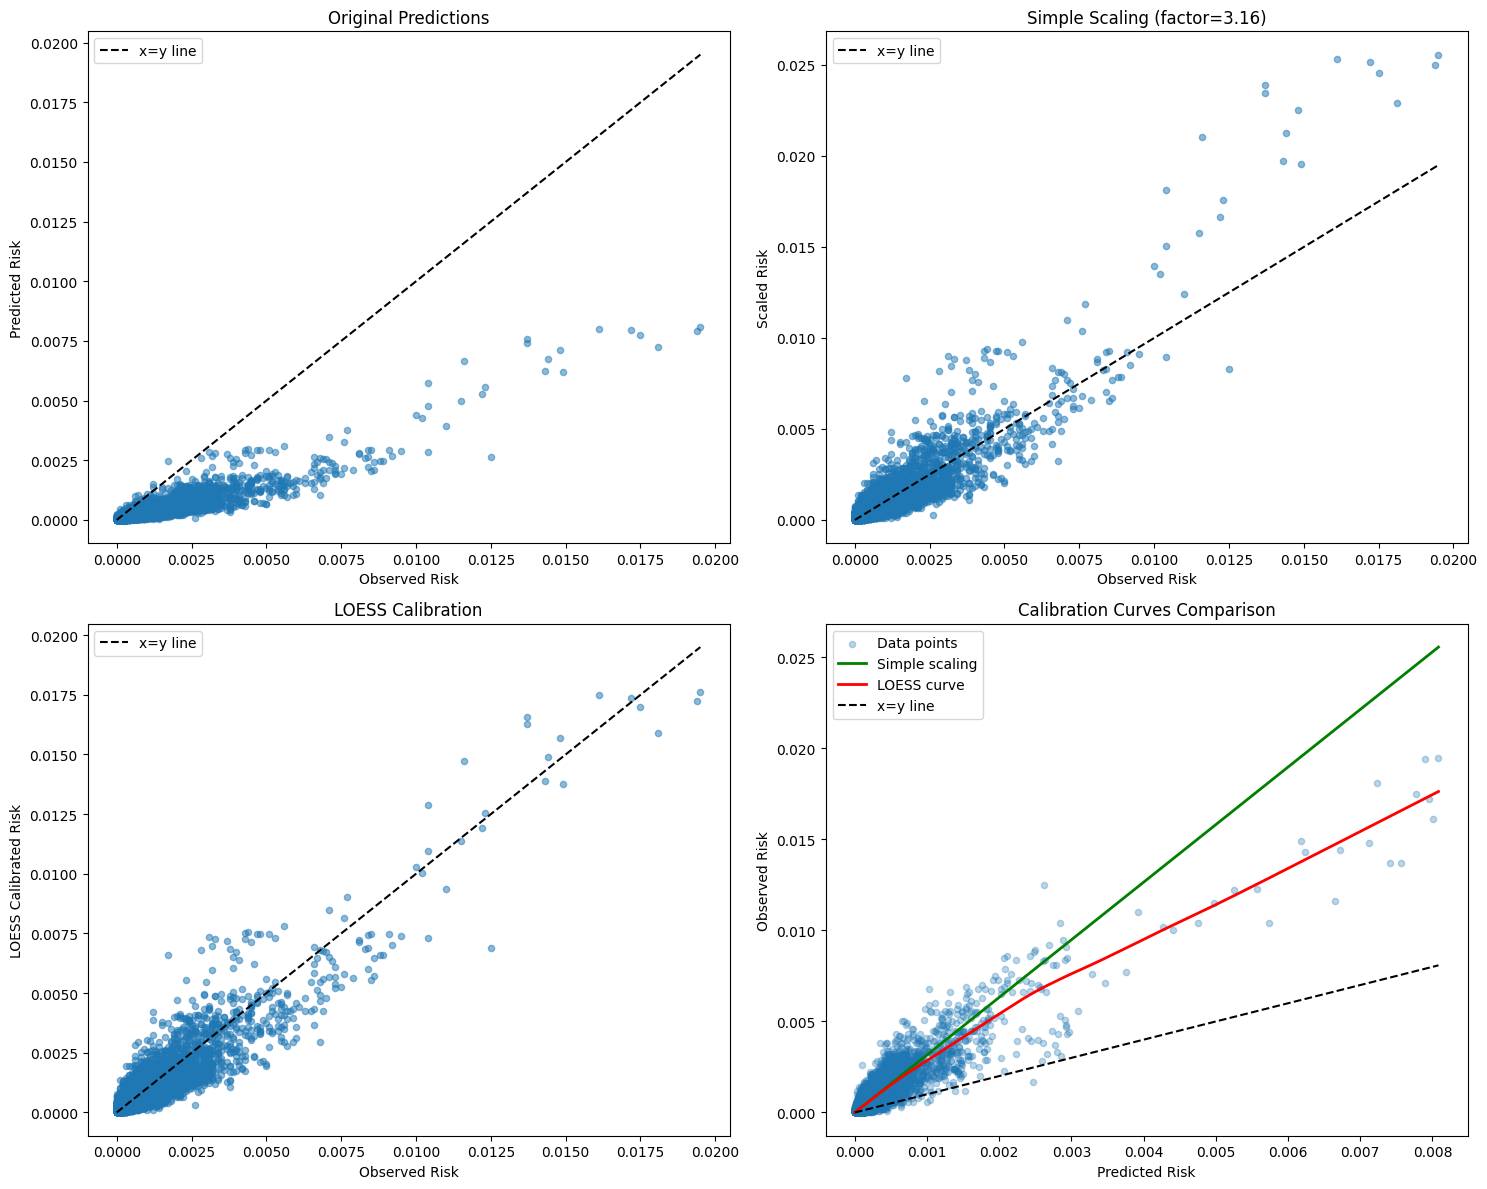


Performance Metrics:
Original R²: 0.434
Simple Scaling R²: 0.777
LOESS Calibrated R²: 0.855

Original RMSE: 0.000695
Simple Scaling RMSE: 0.000436
LOESS Calibrated RMSE: 0.000352


In [59]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.nonparametric.smoothers_lowess import lowess

# Calculate both calibration methods
# Simple scaling
scale_factor = np.mean(observed_risk) / np.mean(predicted_risk)
scaled_risk = predicted_risk * scale_factor

# LOESS calibration
loess_risk = lowess(observed_risk, predicted_risk, frac=0.3, return_sorted=False)

# Create comparison plots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# Original predictions
ax1.scatter(observed_risk, predicted_risk, alpha=0.5, s=20)
ax1.plot([0, max(observed_risk)], [0, max(observed_risk)], 'k--', label='x=y line')
ax1.set_title('Original Predictions')
ax1.set_xlabel('Observed Risk')
ax1.set_ylabel('Predicted Risk')
ax1.legend()

# Simple scaling calibration
ax2.scatter(observed_risk, scaled_risk, alpha=0.5, s=20)
ax2.plot([0, max(observed_risk)], [0, max(observed_risk)], 'k--', label='x=y line')
ax2.set_title(f'Simple Scaling (factor={scale_factor:.2f})')
ax2.set_xlabel('Observed Risk')
ax2.set_ylabel('Scaled Risk')
ax2.legend()

# LOESS calibration
ax3.scatter(observed_risk, loess_risk, alpha=0.5, s=20)
ax3.plot([0, max(observed_risk)], [0, max(observed_risk)], 'k--', label='x=y line')
ax3.set_title('LOESS Calibration')
ax3.set_xlabel('Observed Risk')
ax3.set_ylabel('LOESS Calibrated Risk')
ax3.legend()

# Calibration curves comparison
sort_idx = np.argsort(predicted_risk)
pred_sorted = predicted_risk[sort_idx]
obs_sorted = observed_risk[sort_idx]
smoothed = lowess(obs_sorted, pred_sorted, frac=0.3)

ax4.scatter(predicted_risk, observed_risk, alpha=0.3, s=20, label='Data points')
ax4.plot(pred_sorted, pred_sorted * scale_factor, 'g-', label='Simple scaling', linewidth=2)
ax4.plot(smoothed[:, 0], smoothed[:, 1], 'r-', label='LOESS curve', linewidth=2)
ax4.plot([0, max(predicted_risk)], [0, max(predicted_risk)], 'k--', label='x=y line')
ax4.set_title('Calibration Curves Comparison')
ax4.set_xlabel('Predicted Risk')
ax4.set_ylabel('Observed Risk')
ax4.legend()

plt.tight_layout()
plt.show()

# Print performance metrics
from sklearn.metrics import r2_score, mean_squared_error
print("\nPerformance Metrics:")
print(f"Original R²: {r2_score(observed_risk, predicted_risk):.3f}")
print(f"Simple Scaling R²: {r2_score(observed_risk, scaled_risk):.3f}")
print(f"LOESS Calibrated R²: {r2_score(observed_risk, loess_risk):.3f}")
print(f"\nOriginal RMSE: {np.sqrt(mean_squared_error(observed_risk, predicted_risk)):.6f}")
print(f"Simple Scaling RMSE: {np.sqrt(mean_squared_error(observed_risk, scaled_risk)):.6f}")
print(f"LOESS Calibrated RMSE: {np.sqrt(mean_squared_error(observed_risk, loess_risk)):.6f}")

In [67]:
essentials['prevalence_t']

array([[1.69567120e-05, 1.75893347e-05, 1.88782979e-05, ...,
        1.08835455e-04, 1.04374347e-04, 1.02135520e-04],
       [2.68736881e-06, 2.85423562e-06, 3.20238269e-06, ...,
        1.18538810e-04, 1.14539289e-04, 1.12490707e-04],
       [2.97181600e-07, 3.30504719e-07, 4.04821947e-07, ...,
        3.29991919e-04, 3.24798864e-04, 3.22023610e-04],
       ...,
       [1.33744152e-05, 1.37726638e-05, 1.45833792e-05, ...,
        5.58665721e-04, 5.51545003e-04, 5.47744974e-04],
       [1.67175514e-07, 1.90169047e-07, 2.43914428e-07, ...,
        1.23406190e-03, 1.21272355e-03, 1.20137166e-03],
       [1.02264755e-06, 1.13695830e-06, 1.39220663e-06, ...,
        1.37426832e-04, 1.29557186e-04, 1.25660023e-04]])

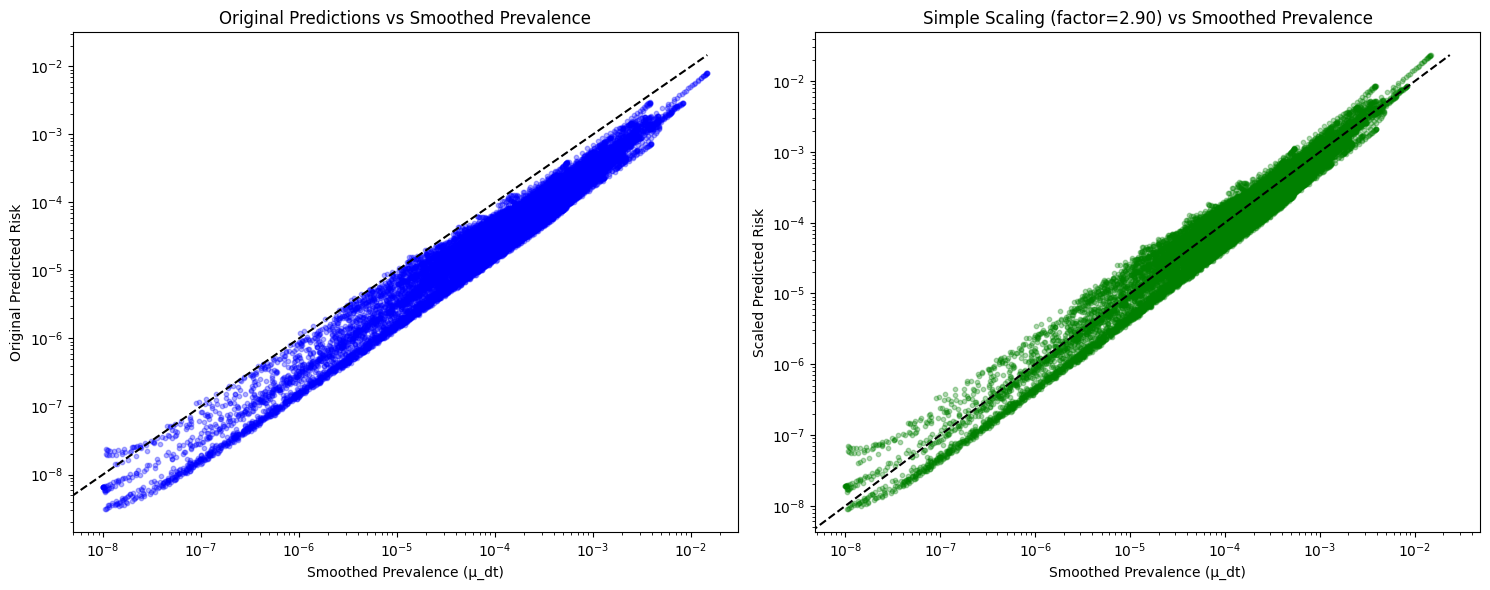

In [68]:
# Get μ_dt from checkpoint and predictions

mu_dt = essentials['prevalence_t'] # Shape: (348, 52)
scale_factor = np.mean(mu_dt) / np.mean(predicted_risk_2d)
scaled_risk_2d = predicted_risk_2d * scale_factor

# Create two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Original predictions vs μ_dt
ax1.scatter(mu_dt.flatten(), predicted_risk_2d.flatten(), 
           alpha=0.3, color='blue', s=10)
ax1.plot([0, max(mu_dt.max(), predicted_risk_2d.max())], 
         [0, max(mu_dt.max(), predicted_risk_2d.max())], 
         'k--', label='x=y')
ax1.set_xlabel('Smoothed Prevalence (μ_dt)')
ax1.set_ylabel('Original Predicted Risk')
ax1.set_title('Original Predictions vs Smoothed Prevalence')
ax1.set_xscale('log')
ax1.set_yscale('log')

# Scaled predictions vs μ_dt
ax2.scatter(mu_dt.flatten(), scaled_risk_2d.flatten(), 
           alpha=0.3, color='green', s=10)
ax2.plot([0, max(mu_dt.max(), scaled_risk_2d.max())], 
         [0, max(mu_dt.max(), scaled_risk_2d.max())], 
         'k--', label='x=y')
ax2.set_xlabel('Smoothed Prevalence (μ_dt)')
ax2.set_ylabel('Scaled Predicted Risk')
ax2.set_title(f'Simple Scaling (factor={scale_factor:.2f}) vs Smoothed Prevalence')
ax2.set_xscale('log')
ax2.set_yscale('log')

plt.tight_layout()
plt.show()